# Part 1: Setup and Data Preparation

#### First, we import all the necessary libraries for data manipulation, cheminformatics, machine learning, and plotting. This includes the models we plan to test and tools for feature engineering and hyperparameter tuning.

In [1]:
import pandas as pd
import numpy as np
import glob
import time
from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Import imblearn for class imbalance handling
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek 
from imblearn.ensemble import BalancedBaggingClassifier 

# Import all models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC 

warnings.filterwarnings("ignore")

# Set a seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Load and Combine Protein Data

### Next, we load the data from all five CSV files. We loop through each file, add a protein_id column to identify the target protein, and then combine them into a single pandas DataFrame.

In [2]:
files = glob.glob("Data/chembl_results_*.csv")
df_list = []
for file in files:
    temp_df = pd.read_csv(file, sep=",")
    protein_id = file.split("_")[2]
    temp_df["protein_id"] = protein_id
    df_list.append(temp_df)
df = pd.concat(df_list, ignore_index=True)

print(df.shape)
print(df.head())

(17425, 23)
   activity_id                                  assay_description  \
0       204991  Inhibitory concentration against Monoamine oxi...   
1      5165981            Inhibition of human monoamine oxidase B   
2     25576087  Inhibition of human MAO-B using p-tyramine as ...   
3      5128648  Inhibition of human recombinant MAOB expressed...   
4     25576086  Inhibition of human MAO-B using p-tyramine as ...   

  molecule_chembl_id standard_units  standard_value target_chembl_id units  \
0       CHEMBL348961             nM           0.014       CHEMBL2039    nM   
1          CHEMBL972             nM           0.017       CHEMBL2039    nM   
2       CHEMBL396778             nM           0.023       CHEMBL2039    nM   
3       CHEMBL315361             nM           0.048       CHEMBL2039    nM   
4          CHEMBL887             nM           0.050       CHEMBL2039    nM   

   value      pIC50                                   smiles  ...  HBA   TPSA  \
0  0.014  10.853872  Cc

In [3]:
bioactivity_count = df["bioactivity_class"].value_counts()
print("\nBioactivity Class Distribution:\n", bioactivity_count)


Bioactivity Class Distribution:
 bioactivity_class
Active      14851
Inactive     2574
Name: count, dtype: int64


# One-Hot Encode Proteins

### To use the categorical protein identity as a feature in our model, we convert the protein_id column into a numerical format using one-hot encoding. This creates a new binary column for each protein.

In [4]:
protein_dummies = pd.get_dummies(df["protein_id"], prefix="protein")
protein_dummy_cols = protein_dummies.columns.tolist()
df = pd.concat([df, protein_dummies], axis=1)

print("One-hot encoded columns created and their names have been stored.")
print("Example of stored columns:")
print(protein_dummy_cols[:5])

One-hot encoded columns created and their names have been stored.
Example of stored columns:
['protein_P27338', 'protein_P35354', 'protein_P43490', 'protein_P56817', 'protein_Q04844']


# Generate Molecular Fingerprints

### We define a function to convert the SMILES strings of the molecules into Morgan fingerprints. These are numerical vectors that represent the molecule's structure, which the machine learning model can understand.

In [5]:
def smiles_to_fp(smiles, radius=3, n_bits=2048):
    try:
        mol = Chem.MolFromSmiles(smiles)
        fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=n_bits)
        fp = fp_gen.GetFingerprintAsBitVect(mol)
        return np.array(fp)
    except:
        return np.zeros(n_bits)
df["fp"] = df["smiles"].apply(smiles_to_fp)

# Feature Engineering - Physicochemical Descriptors

### To improve our model, we engineer new features beyond fingerprints. Here, we calculate five important physicochemical properties for each molecule (like Molecular Weight and LogP) that can help the model learn.

In [6]:
def get_physchem_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return [np.nan] * 5
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        tpsa = Descriptors.TPSA(mol)
        return [mw, logp, hbd, hba, tpsa]
    except:
        return [np.nan] * 5

descriptor_names = ["MolWt", "MolLogP", "NumHDonors", "NumHAcceptors", "TPSA"]
df[descriptor_names] = df["smiles"].apply(get_physchem_descriptors).apply(pd.Series)
df.dropna(inplace=True)
print("Physicochemical descriptors calculated.")

Physicochemical descriptors calculated.


# Prepare Final Data for Modeling

### Now we assemble our final feature matrix, X, by combining the fingerprints, the one-hot encoded protein IDs, and our new scaled physicochemical descriptors. The target variable y is also defined and converted to a numeric format.

In [7]:
# --- 1. Fingerprints ---
fp_df = pd.DataFrame(
    df["fp"].to_list(),
    index=df.index,
    columns=[f'fp_{i}' for i in range(df["fp"].iloc[0].shape[0])]
)

# --- 2. One-Hot Encoded Proteins ---
protein_df = df[protein_dummy_cols]

# --- 3. Physicochemical Descriptors (and Scaling) ---
descriptor_df = df[descriptor_names]
scaler = StandardScaler()
scaled_descriptor_df = pd.DataFrame(scaler.fit_transform(descriptor_df),
                                    index=descriptor_df.index,
                                    columns=descriptor_df.columns)

# --- Combine all features into the final feature matrix X ---
X = pd.concat([fp_df, protein_df, scaled_descriptor_df], axis=1)

# --- Define the target variable y ---
y = df["bioactivity_class"].map({'Active': 1, 'Inactive': 0})

# --- Ensure all column names are strings ---
X.columns = X.columns.astype(str)

print("Final feature matrix X created with all string column names.")
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Final feature matrix X created with all string column names.
Shape of X: (17425, 2058)
Shape of y: (17425,)


# Split Data into Training and Test Sets

### We split our dataset into a training set (which we use to teach the model) and a test set (which we use to evaluate its performance on unseen data). This ensures our evaluation is fair and unbiased.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y # Stratified sampling for imbalance
)
print("Data split into training and test sets.")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Data split into training and test sets.
Shape of X_train: (13940, 2058)
Shape of X_test: (3485, 2058)


# Part 2: Model Training and Optimization

## Define and Evaluate Baseline Models

### This begins our analysis. We will train three different baseline models to see which algorithm performs best on our new feature set. This allows us to select the most promising model for further optimization.



In [10]:
models = [
    {"label": "Random Forest", "model": RandomForestClassifier(n_estimators=100, random_state=SEED)},
    {"label": "Gradient Boosting", "model": GradientBoostingClassifier(random_state=SEED)},
    {"label": "Neural Network", "model": MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.001, learning_rate_init=0.001, max_iter=500, early_stopping=True, validation_fraction=0.1, random_state=SEED)}, # Added ANN
]

results = []
print("Starting baseline model training and evaluation...")

for model_item in models:
    print(f"\n===== Training {model_item['label']} =====")
    model = model_item["model"]
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # --- Calculate and add fpr/tpr for plotting ---
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # --- Add more evaluation metrics ---
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Training Time: {training_time:.2f}s | Accuracy: {accuracy:.4f} | AUC: {auc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    
    # --- Store fpr/tpr and other metrics in the results list ---
    results.append({
        "label": model_item['label'], 
        "model": model,
        "training_time": training_time, 
        "accuracy": accuracy, 
        "auc": auc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "confusion_matrix": cm,
        "fpr": fpr, 
        "tpr": tpr  
    })

# --- Cross-validation for each baseline model ---
print("\n--- Performing Cross-Validation for each baseline model (5-fold) ---")
for model_item in models:
    print(f"\n===== Cross-validating {model_item['label']} =====")
    model = model_item["model"]
    # Ensure probability is True for SVC if it's the best model or being cross-validated
    if isinstance(model, SVC):
        model.probability = True
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
    print(f"  Cross-Validation AUC Scores: {cv_scores}")
    print(f"  Mean CV AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

Starting baseline model training and evaluation...

===== Training Random Forest =====
Training Time: 24.63s | Accuracy: 0.8683 | AUC: 0.8203 | Precision: 0.8912 | Recall: 0.9630 | F1-Score: 0.9257
Confusion Matrix:
 [[ 166  349]
 [ 110 2860]]

===== Training Gradient Boosting =====
Training Time: 17.21s | Accuracy: 0.8571 | AUC: 0.7632 | Precision: 0.8612 | Recall: 0.9923 | F1-Score: 0.9221
Confusion Matrix:
 [[  40  475]
 [  23 2947]]

===== Training Neural Network =====
Training Time: 20.49s | Accuracy: 0.8522 | AUC: 0.6394 | Precision: 0.8522 | Recall: 1.0000 | F1-Score: 0.9202
Confusion Matrix:
 [[   0  515]
 [   0 2970]]

--- Performing Cross-Validation for each baseline model (5-fold) ---

===== Cross-validating Random Forest =====
  Cross-Validation AUC Scores: [0.59707588 0.18149913 0.1393995  0.7395296  0.68287961]
  Mean CV AUC: 0.4681 (+/- 0.2556)

===== Cross-validating Gradient Boosting =====
  Cross-Validation AUC Scores: [0.57017741 0.01678729 0.10721127 0.69374195 0.60

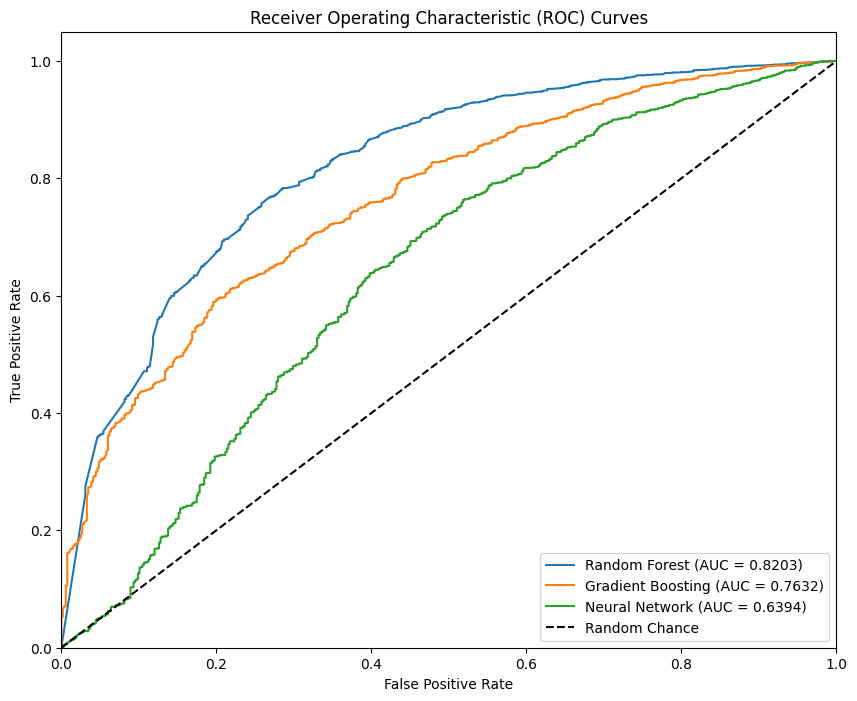

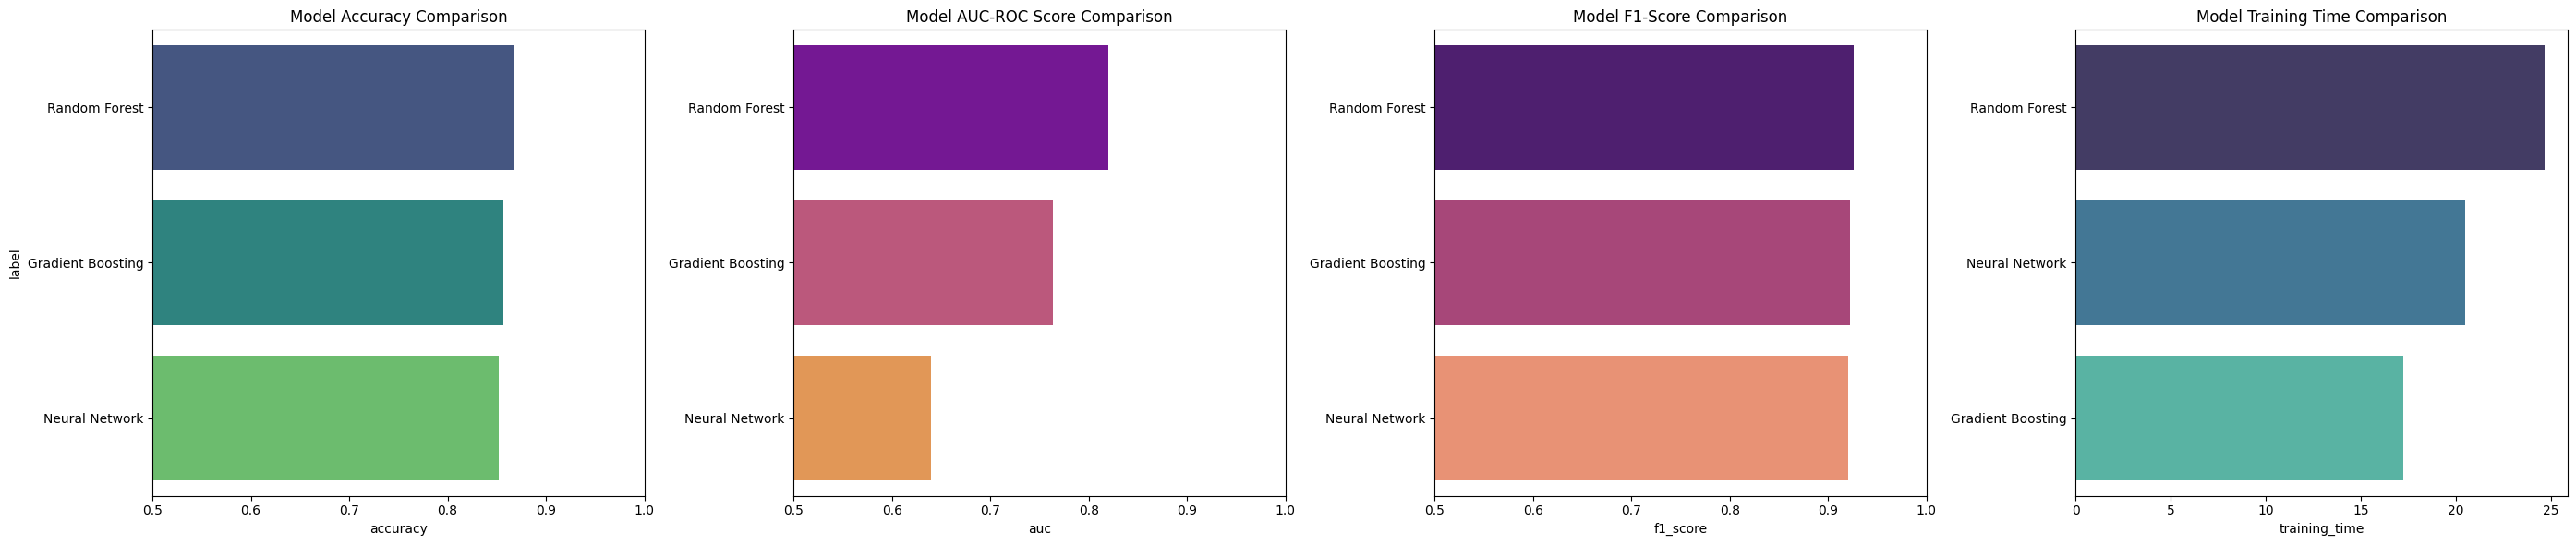

In [11]:
results_df = pd.DataFrame(results)

# Plot 1: Combined ROC Curves
plt.figure(figsize=(10, 8))
for res in results:
    plt.plot(res['fpr'], res['tpr'], label=f"{res['label']} (AUC = {res['auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="lower right")
plt.savefig("figures/roc_curves_comparison.png")
plt.show()

# Plot 2, 3 & 4: Accuracy, AUC, F1-Score, and Training Time
fig, axes = plt.subplots(1, 4, figsize=(28, 6)) # Increased figsize for 4 plots

sns.barplot(x="accuracy", y="label", data=results_df.sort_values("accuracy", ascending=False), palette="viridis", ax=axes[0])
axes[0].set_title("Model Accuracy Comparison")
axes[0].set_xlim([0.5, 1.0])

sns.barplot(x="auc", y="label", data=results_df.sort_values("auc", ascending=False), palette="plasma", ax=axes[1])
axes[1].set_title("Model AUC-ROC Score Comparison")
axes[1].set_xlim([0.5, 1.0])
axes[1].set_ylabel("")

sns.barplot(x="f1_score", y="label", data=results_df.sort_values("f1_score", ascending=False), palette="magma", ax=axes[2]) # Added F1-score plot
axes[2].set_title("Model F1-Score Comparison")
axes[2].set_xlim([0.5, 1.0])
axes[2].set_ylabel("")

sns.barplot(x="training_time", y="label", data=results_df.sort_values("training_time", ascending=False), palette="mako", ax=axes[3])
axes[3].set_title("Model Training Time Comparison")
axes[3].set_ylabel("")

plt.tight_layout()
plt.show()

In [12]:
# Programmatically find the best model from Part 1 based on AUC score
best_model_result = max(results, key=lambda x: x['auc'])
best_model_label = best_model_result['label']
print(f"\nBest performing model from baseline tests is: {best_model_label} (AUC: {best_model_result['auc']:.4f})")
print("Now proceeding to tune this model...")

param_grid = {}

if best_model_label == "Gradient Boosting":
    param_grid = {'n_estimators': [200, 300], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
elif best_model_label == "Random Forest":
    param_grid = {'n_estimators': [200, 300], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
elif best_model_label == "Neural Network": 
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001],
        'learning_rate_init': [0.001, 0.01]
    }
elif best_model_label == "Support Vector Machine": 
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }


Best performing model from baseline tests is: Random Forest (AUC: 0.8203)
Now proceeding to tune this model...


In [13]:
if not param_grid:
    print("Best model is not set up for tuning in this script. Saving the untuned version.")
    best_model = best_model_result['model']
else:
    print(f"Tuning {best_model_label} with grid: {param_grid}")
    print("This may take some time...")
    
    model_to_tune = [m['model'] for m in models if m['label'] == best_model_label][0]

    # --- Explicit Imbalance Handling using SMOTETomek ---
    # Apply SMOTETomek to the training data before GridSearchCV
    print(f"\nApplying SMOTETomek for imbalance handling to {best_model_label} training data...")
    smote_tomek = SMOTETomek(random_state=SEED) # SMOTETomek for oversampling and cleaning
    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)
    
    print(f"Original training shape: {X_train.shape}, {y_train.shape}")
    print(f"Resampled training shape: {X_train_resampled.shape}, {y_train_resampled.shape}")
    
    # Use resampled data for GridSearchCV
    grid_search = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, 
                               cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')
    grid_search.fit(X_train_resampled, y_train_resampled) # Fit on resampled data
    
    print("\nHyperparameter tuning complete.")
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation AUC score: ", grid_search.best_score_)
    best_model = grid_search.best_estimator_

Tuning Random Forest with grid: {'n_estimators': [200, 300], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
This may take some time...

Applying SMOTETomek for imbalance handling to Random Forest training data...


  File "C:\Users\HaMMaDy\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\HaMMaDy\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\HaMMaDy\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\HaMMaDy\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Original training shape: (13940, 2058), (13940,)
Resampled training shape: (23320, 2058), (23320,)
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Hyperparameter tuning complete.
Best parameters found:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation AUC score:  0.9604604369541292


In [15]:
# Evaluate the final model on the test set
final_y_pred_proba = best_model.predict_proba(X_test)[:, 1]
final_y_pred = best_model.predict(X_test)

final_auc = roc_auc_score(y_test, final_y_pred_proba)
final_accuracy = accuracy_score(y_test, final_y_pred)
final_precision = precision_score(y_test, final_y_pred)
final_recall = recall_score(y_test, final_y_pred)
final_f1_score = f1_score(y_test, final_y_pred)
final_confusion_matrix = confusion_matrix(y_test, final_y_pred)

print("\n--- Final Tuned Model Performance on Test Set ---")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"AUC-ROC Score: {final_auc:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-Score: {final_f1_score:.4f}")
print("Confusion Matrix:\n", final_confusion_matrix)

# --- Cross-validation for the final best model ---
print(f"\n--- Performing Cross-Validation for the final tuned {best_model_label} model (5-fold) ---")
# Ensure probability is True for SVC if it's the best model
if isinstance(best_model, SVC):
    best_model.probability = True
cv_scores_final_model = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print(f"  Cross-Validation AUC Scores (Tuned Model): {cv_scores_final_model}")
print(f"  Mean CV AUC (Tuned Model): {np.mean(cv_scores_final_model):.4f} (+/- {np.std(cv_scores_final_model):.4f})")

# Save the final model object (which includes the scaler)
model_to_save = {
    "model": best_model,
    "scaler": scaler,
    "feature_names": X.columns.tolist()
}
joblib.dump(model_to_save, "Data/final_tuned_model.pkl")
print(f"\nFinal tuned model saved to final_tuned_model.pkl")


--- Final Tuned Model Performance on Test Set ---
Accuracy: 0.8270
AUC-ROC Score: 0.8228
Precision: 0.9163
Recall: 0.8771
F1-Score: 0.8963
Confusion Matrix:
 [[ 277  238]
 [ 365 2605]]

--- Performing Cross-Validation for the final tuned Random Forest model (5-fold) ---
  Cross-Validation AUC Scores (Tuned Model): [0.62575388 0.15772547 0.13753392 0.74277467 0.68719329]
  Mean CV AUC (Tuned Model): 0.4702 (+/- 0.2660)

Final tuned model saved to final_tuned_model.pkl
